# TP Observations Nocturnes - LU3PY232
**ARGUELLO Camilo**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from utils import pc2m, m2pc, dms2deg, deg2dms, flux2mag, mag2flux, distance_modulus, apparent_to_absolute_flux
from constants import ConstantesAstro
from matplotlib.colors import LogNorm
from astropy.stats import sigma_clip
import os 
import glob
import warnings
#import astroalign as aa
from photutils.aperture import aperture_photometry, CircularAperture
from photutils.centroids import centroid_quadratic
import processing as  pr
import utils
from IPython.display import display, Math

/opt/anaconda3/envs/LU3PY232/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Introduction et Contexte

### Objectifs du TP

Ce TP vise à étudier la relation d’échelle entre la taille et la luminosité des galaxies de l’univers proche. 
Nous allons utiliser des images obtenues à l'aide de télescopes à distance pour :

- Calibrer des images photométriques (offset, flat field),
- Extraire des informations scientifiques (taille, luminosité),
- Comparer les résultats avec les théories d’assemblage galactique.

### Diversité morphologique des galaxies

Les galaxies dans l'univers présentent une diversité morphologique remarquable. Dans la littérature, on trouve qu'elles sont classifiées selon la séquence de Hubble [1], où l'on peut distinguer plusieurs groupes :

- **Les galaxies elliptiques**, avec une forme ovoïde, sont composées principalement d'étoiles âgées et contiennent peu de gaz et de poussière [2].
- **Les galaxies spirales**, comme notre Voie Lactée, possèdent un disque aplati avec des bras spiraux où se concentre la formation stellaire, entourant un bulbe central plus dense [3].
- **Les galaxies irrégulières**, qui ne montrent pas de structure définie, sont souvent le résultat d'interactions gravitationnelles [4].

Dans ce TP, nous nous concentrerons sur les galaxies **elliptiques** et **spirales**, qui représentent les deux morphologies dominantes dans l'univers [5].

### Loi d'échelle taille-luminosité

//  explication des relations taille-masse et leur interprétation physique

### Galaxie M83 (Messier 83)

Elle est l'une des galaxies spiraless les plus brillantes et les plus proches de la Terre. Situé à environ `4.66` Mpc. D'un point vue de ce TP elle constitue un excellent laboratoire pour étudier la structure et forme des galaxies spirales d'après son orientation face-à-face vers la Terre, ainsi que ces régions brillantes.

## 2. Prise en main et visualisation des images

Pour ce TP on est intéressés à l'obtention d'informations sur des galaxies observables depuis le centre d'observation *Siding Spring Observatory (SSO)* en Australie (GMT+10). Pour ce faire, on utilisera plusieurs outils:

- Dans un premier temps, on planifiera une observation sur la plateforme [telescopius.com](https://telescopius.com) pour identifier, à partir d'un centre d'observation et sur une période donnée les galaxies potentiellement observables. Cela inclut le temps d'exposition et l'heure de passage optimale.
- Ensuite, nous allons faire une demande d'observation sur la plateforme [itelescope.net](https://itelescope.net). On choisira d'abord un Telescope, selon la disponibilité. Parmi les telescopes les plus utilises, nous allons utiliser le T17, le T30, le T32, et le T33. Pour cela on creera un script qui contiendra les informations par rapport la galaxie a observer, les binings et un temps d'exposition d'environ 300s. Cette plateforme permet également d'obtenir des observations sur une gamme differentes de filtres, on se concentrera sur les filtres rouge, bleu et vert qui nous donnent beaucoup plus de données.
- Ces données pourront être traitées par la suite à l'aide du logiciel DS9, ainsi qu'avec du python et ses bibliothèques `photoutils` et `astrophy`.
- Pour rendre le TP plus facile à lire, on guardera toutes les fonctions crées dans le fichier `utils.py` et `processing.py`.

On commence tout d'abord par l'analyse des données recueillies concernant la galaxie M83, un gallaxie assez connue et quie est observable depuis le SSO en Australie. On pourra ainsi, dans la première partie du TP, répondre aux questions en nous appuyant sur ces données.

> Quel est l’ordre de grandeur de la brillance de surface des etoiles ?  la brillance de surface du fond de ciel ? La brillance de surface de la galaxie ? En quelle unit´e est le flux sur ces images non-calibrées ?

Sur le logiciel DS9, on mesure manuellement les valeurs pour une région définie. Cette approche permet d'obtenir la valeur moyenne.

Dans le logiciel DS9, nous mesurons les valeurs en sélectionnant des régions spécifiques grâce aux outils de région (cercle, rectangle, etc.). Pour notre analyse, nous utilisons principalement l'outil circulaire qui permet de définir précisément la zone d'intérêt. Une fois la région sélectionnée, DS9 calcule automatiquement diverses statistiques dont la valeur moyenne des pixels dans cette zone. Pour chaque mesure, nous avons défini 2-3 régions circulaires afin d'obtenir des valeurs représentatives.

| Zone     | Brillance de surface   |
|----------|------------------------|
| Étoiles  | $\approx 600 - 2500 $ |
| Fond de ciel  |  $\approx 600 - 700 $  |
| Galaxie  | $\approx 700 - 2300 $  |

$ \small{\text{Tableau 1. Grandeur de brillance selon la zone}} $

> Quelle est la durée de la pose ? Quelle était la date d’observation ?

Les fichiers *.fit sont très utilisés en astronomie pour stocker une grande quantité d'informations. Ils peuvent contenir aussi bien des images que des tableaux. Ces fichiers sont structurés en deux parties : un `HEADER` (en-tête) et un `BODY` (corps) contenant l'ensemble des données. Le `HEADER` nous permet notamment d'accéder aux métadonnées de l'observation, telles que la durée de pose et la date d'observation.

```ts
EXPTIME =   140.00000000000000 /Exposure time in seconds
DATE-OBS= '2023-05-09T11:32:42.84' /YYYY-MM-DDThh:mm:ss observation, UT
```

> Que pouvez-vous dire de la qualité de cette image ? Quelle est la valeur typique du fond de ciel ?

Concernant les observations réalisées de la galaxie M83, on dispose d'images brutes de bonne qualité. Néanmoins, nous pouvons observer quelques artefacts dus à des erreurs de mesure, ainsi qu'une distribution non uniforme du fond de ciel. Les étoiles apparaissent bien définies et ponctuelles, bien que certaines soient légèrement saturées.

Nous effectuerons une première visualisation des données à l'aide de la fonction `plot_initial_filter_sequence` qui nous permettra d'afficher l'ensemble des filtres disponibles pour M83.

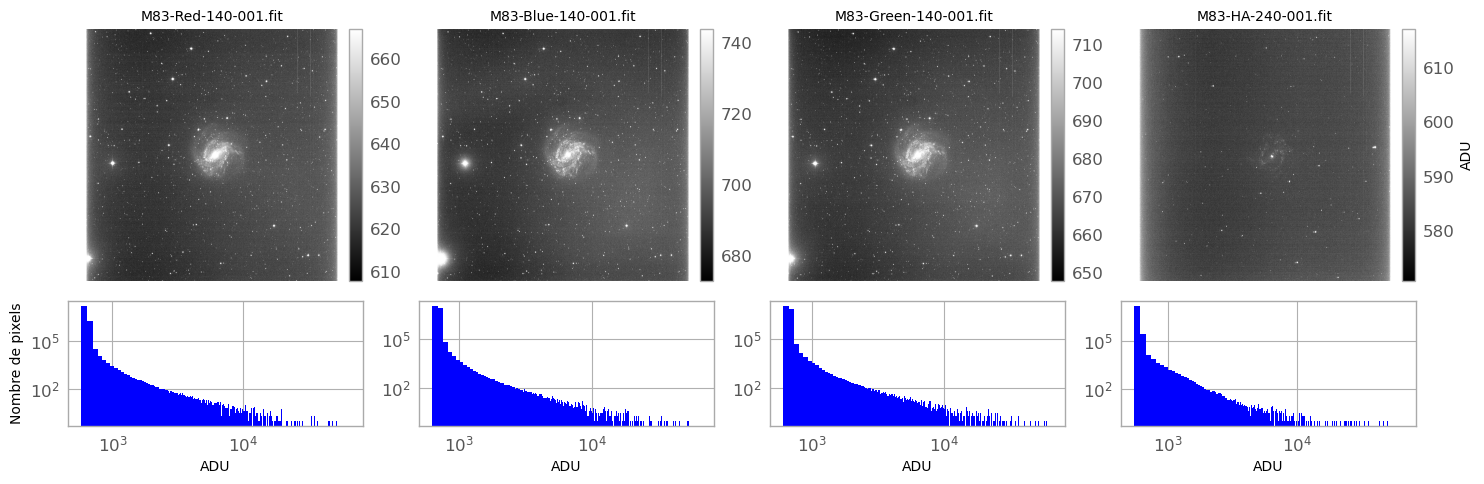

In [3]:
utils.plot_initial_filter_sequence()

> Répondez aux mêmes questions avec une image dans un autre filtre. Que constatez vous ? Faites bien attention à prendre en compte le temps de pose lorsque vous comparez les flux.

In [71]:
utils.get_exposure_times([
    { 'filter_name': 'Red', 'pathname':'./M83/M83-Red-140-001.fit' },
    { 'filter_name': 'Blue', 'pathname':'./M83/M83-Blue-140-001.fit' },
    { 'filter_name': 'Green', 'pathname':'./M83/M83-Green-140-001.fit' },
    { 'filter_name': 'HA', 'pathname':'./M83/M83-HA-240-001.fit' }
])

Temps de pose pour le filtre Red : 140.0 s
Temps de pose pour le filtre Blue : 140.0 s
Temps de pose pour le filtre Green : 140.0 s
Temps de pose pour le filtre HA : 240.0 s


En analysant les images de M83 à travers différents filtres, on peut faire plusieurs remarques.

1. Chaque filtre permet d'observer la galaxie dans une gamme spécifique de longueurs d'onde. De même, les temps de pose `EXPTIME` varient selon les filtres. 140s en rouge, bleu et vert et 240s en Ha. Dans la litérature on trouve que la galaxie M83 présente des régions d'hydrogène ionisé (HII), particulièrement visibles dans le filtre Ha [6].

2. En analysante les brillances:

**Étoiles**:  On voit les étoiles plus brillantes dans le filtre bleu, qui est un indicateur d'étoiles jeunes et chaudes. De mêeme on les voit plus intenses dans le filtre rouge : signature d'étoiles plus âgées et froides [7].

**Fond de ciel** : On voit un niveau très élevé dans les filtres rouge et Ha, cela dû probablement à la pollution lumineuse artificielle [8].

**Galaxie** : On peut la voit très brillante en bleu et vert qui montre un révèle les régions de formation stellaire active. Aussi, moins visible en Ha : l'émission Ha trace spécifiquement les régions HII, qui sont plus localisées et moins étendues que la distribution stellaire générale [9]

> Convertissez la taille d’un pixel sur l’image en secondes d’arc puis en kiloparsecs, sachant la distance de cette galaxie (se référer au fichier excel `TP 2025 galaxies.xlsx`). Justifiez. En le mesurant “à la main”, quel est le rayon caractéristique ce cette galaxie, en `kpc` ?

In [4]:
# M83 
# Telescope: T32 dans l'observatoire SSO en Australie.
galaxy_name = "M83"
galaxy_type = 'spiral'
FOCALLEN = 2912            # distance focale en mm
XPIXSZ = 9e-3              # taille du pixel en mm (9 microns)
distance_mpc = 4.66        # distance depuis la Terre en Mpc
angular_size_arcsec = 600  # taille angulaire mesurée en arcsec

pixel_size = utils.get_pixel_size(XPIXSZ, FOCALLEN)  # arcsec / pixel
print(f"Pixel size théorique : {pixel_size:.3f} arcsec/pixel")

physical_size_pc, physical_size_kpc = utils.get_physical_size(angular_size_arcsec, distance_mpc)
print(f"Taille physique de la galaxie : {physical_size_pc:.2f} pc ({physical_size_kpc:.2f} kpc)")

Pixel size théorique : 0.637 arcsec/pixel
Taille physique de la galaxie : 13555.39 pc (13.56 kpc)


## 3. Calibration des images

Dans cette section, nous abordons la calibration des images de M83. Cette étape cruciale commence par l'analyse des fichiers "bias" (offset), générés lors des observations. Ces fichiers sont essentiels car ils permettent de caractériser le signal parasite inhérent au détecteur CCD [10].

**Principe du bias**

En l'absence totale de lumière, le bias est une signal électronique parasite qu'on peut appercevoir comme une image avec un temps de pose minimal ($ \sim 0.001$ s). Cette mesure est fondamentale car les capteurs CCD présentent systématiquement un niveau de base non nul, appelé "piédestal électronique". Ce signal parasite provient du bruit de lecture du détecteur, ou des fluctuations électroniques du système.

**Processus de calibration**

La soustraction du bias des images brutes permet d'éliminer cette composante systématique du signal. Cette étape est réalisée en plusieurs étapes :

1. Acquisition de multiples poses de bias
2. Combinaison de ces poses pour créer un "master bias"
3. Soustraction du master bias de chaque image brute

Cette procédure est essentielle pour obtenir des mesures photométriques précises et exploitables.

### Construction de la pose maitre d’offset

> Affichez l’histogramme des valeurs des pixels. Autour de quelle valeur se trouve l’offset piédestal ?

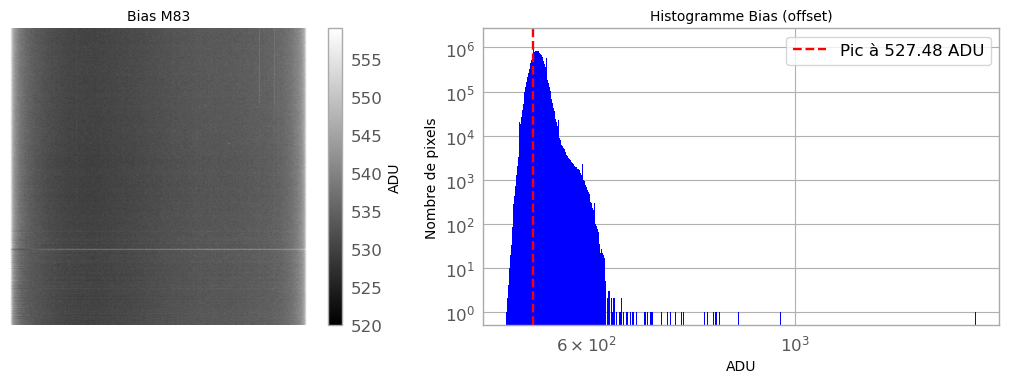

In [98]:
utils.plot_bias_hist('Bias/T32-fetedelascience-Bias-000-LD20230411-LT152814-BIN1.fit', 'M83')

Pour déterminer la valeur de l'offset (piédestal), nous utilisons la valeur centrale de la distribution. Nous obtenons ainsi une valeur de piédestal de `527.48` ADU.

Il est important de noter que le bias peut varier d'un pixel à l'autre. C'est pourquoi nous devons acquérir plusieurs images de bias qui, une fois combinées, permettront de réduire le bruit statistique. Cette combinaison, c'est bien le "Master bias", et il sera stocké dans un nouveau fichier contenant les valeurs moyennes de toutes les images analysées.

Ce fichier sera créé dans le dossier `/Processed` à l'aide de la fonction `master_bias`. Cette fonction a été optimisée et améliorée, notamment par l'introduction du paramètre `sigma` utilisé par la fonction `sigma_clip(..)`. Ce paramètre permet de filtrer efficacement les valeurs aberrantes qui s'écartent trop de la valeur centrale.

In [99]:
output_dir = "./Processed/"
list_bias_name = glob.glob('./Bias/*.fit')


On se pose comme objectif de déterminer la valeur optimale de la constante `sigma`. Cette valeur est cruciale pour affiner le calcul de la médiane appliquée au bias. Pour cela, nous allons :

1. Comparer les résultats obtenus entre :
   - L'application de la médiane seule
   - L'application de la médiane combinée avec la fonction `sigma_clip(..)`

2. Analyser le pourcentage de pixels modifiés en fonction de différentes valeurs de `sigma`

Cette approche nous permettra de quantifier l'impact du paramètre `sigma` sur la qualité du traitement des données

Chargement de 13 poses de bias...

Meilleur sigma: 3


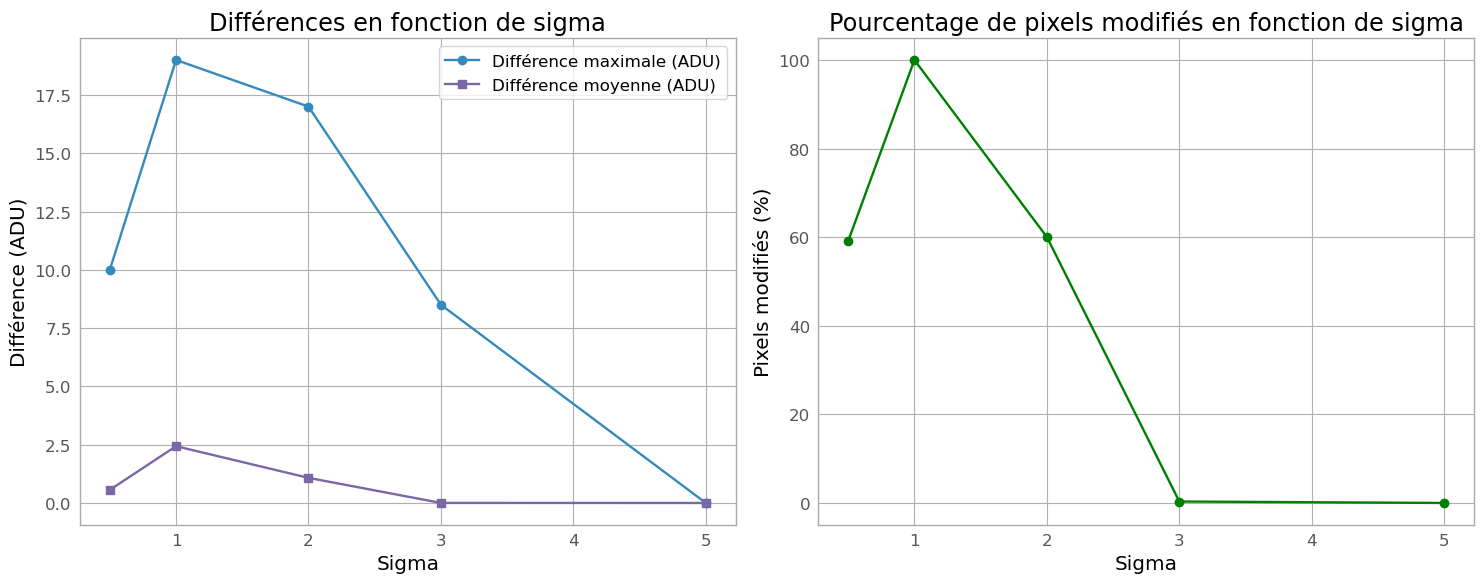

In [100]:
best_sigma, _, _ = pr.get_best_sigma_for_master_bias(list_bias_name)


À partir des valeurs de $\sigma = 0.5$ jusqu'à $5$, nous observons que les différences diminuent graduellement entre le filtre médian avec et sans sigma.

Cette tendance est due à deux phénomènes principaux :

1. Pour les faibles valeurs de $\sigma$ ($< 1$), le filtre est très restrictif et élimine une grande proportion de pixels, y compris certains qui pourraient contenir de l'information utile.

2. Pour les grandes valeurs de $\sigma$ ($> 3$), le filtre devient trop permissif et tend vers un comportement similaire à une simple médiane, car peu de pixels sont considérés comme aberrants.

Le choix optimal de $\sigma$ se situe généralement entre 2 et 3, ce qui permet d'éliminer efficacement les pixels défectueux tout en préservant l'information utile.

In [101]:

master_bias, master_bias_name, master_bias_no_sigma = pr.master_bias(list_bias_name, out_dir=output_dir, out_name='masterbias.fits', overwrite=1, sigma=best_sigma, out_master_bias_no_sigma='masterbias_no_sigma.fits')

il y a 13 poses de bias dans la liste
le master bias a été sauvé en ./Processed/masterbias.fits
le master bias sans sigma a été sauvé en masterbias_no_sigma.fits


On pourra donc observer les differences entre les histogrammes avec et sans sigma. Ainsi que les images obtenues du master Bias. On voit de differences remarquables avec le filtre sigma.

On pourra donc faire une analyse des histogrammes pour observer les différences significatives entre le traitement avec et sans le filtre `sigma`. Les images du master bias obtenues montrent des résultats très similaires. La distribution des valeurs autour de la médiane, ainsi que la réduction du bruit dans les zones périphériques. Finalement, d'un côté on voit que pour les images obtenues, il suffit d'appliquer un filtre médiane. Car on pourrait trouver des cas où le filtre `sigma` soit un peu permissif et laisse passer des pixels. Cela explique dans l'image à gauche la trace rouge pour des valeurs élevées.

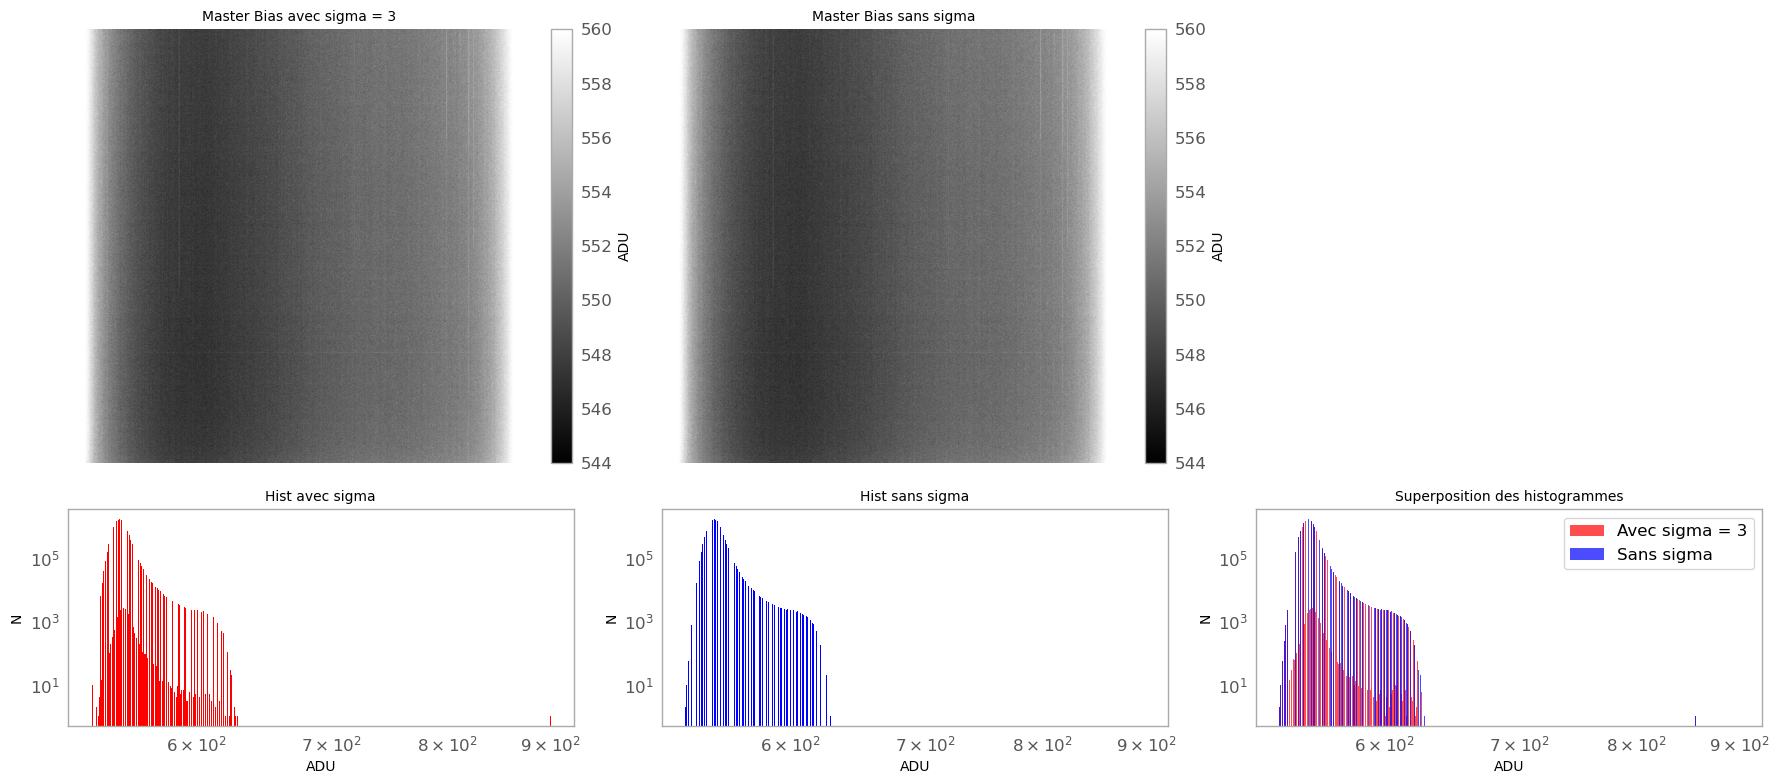

In [102]:
files = [
    ('Processed/masterbias.fits', 'Master Bias avec sigma = ', True),
    ('Processed/masterbias_no_sigma.fits', 'Master Bias sans sigma', False)
]

utils.plot_bias_hist_sigma_stack(files, sigma=best_sigma)

In [103]:
# Charger une pose individuelle (exemple de la première image)
bias_example = fits.getdata(list_bias_name[0])

print("---- Pose individuelle ----")
print(f"Moyenne : {np.mean(bias_example):.2f}")
print(f"Ecart-type : {np.std(bias_example):.2f}")

print("---- Master Bias ----")
print(f"Moyenne : {np.mean(master_bias):.2f}")
print(f"Ecart-type : {np.std(master_bias):.2f}")

---- Pose individuelle ----
Moyenne : 555.11
Ecart-type : 9.05
---- Master Bias ----
Moyenne : 551.03
Ecart-type : 5.90


Finalement, on voit la proximité des valeurs moyennes entre une pose individuelle (`555.11` ADU) et le master bias (`551.03` ADU) est cruciale car elle confirme la stabilité du niveau de base du détecteur CCD.

De même, la réduction de l'écart-type (de `9.05` à `5.90` ADU) peut s'expliquer d'après la combinaison de plusieurs poses de bias. Cela permet donc de moyenner le bruit de lecture aléatoire. Avec cette amélioration la précision de la soustraction du bias augmente, permettant ainsi de mieux détecter les signaux faibles dans nos observations.

### Analyse des poses maitres de champ plat

> Quelle est la valeur moyenne des pixels ? En tracer l’histogramme. En pratique, à quoi correspond la correction de champ plat ? Comment la calibration est-elle obtenue ?

Une observation astronomique peut présenter plusieurs défis techniques avant d'être considérée comme fiable. Ces difficultés proviennent principalement de trois sources :

1. Les variations de sensibilité du capteur CCD.
2. La présence de poussière et les effets de vignettage optique.
3. Les imperfections de l'instrument créant des pixels anormalement clairs ou sombres.

Pour corriger ces effets, on utilise une technique de calibration appelée `master_flat`. Cette méthode consiste à diviser l'image brute par une image de champ plat (flat field) obtenue lors des observations. Cette correction doit être appliquée en séquence avec la correction du bias pour obtenir un résultat cohérent.

Le processus complet de calibration peut être résumé par l'équation suivante :

$$ I_{calibrée} = \frac{I_{brute} - Master\ Bias}{Master\ Flat} $$

où $I_{calibrée}$ représente l'image finale corrigée de tous les effets instrumentaux.

Voyons donc un exemple d'une `master flat`.

Valeur moyenne des pixels: 1.00 ADU


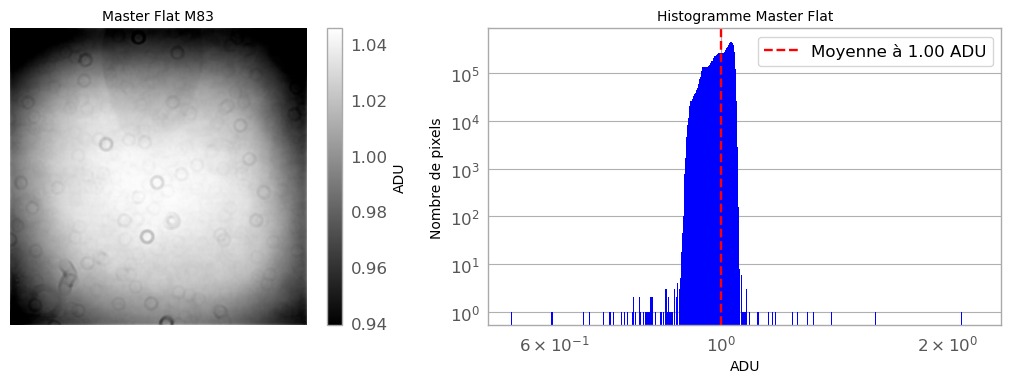

In [104]:
utils.plot_master_flat_hist('./flats_maitre/master_flat--Red-T32.fits', 'M83')

## 4. Pipeline de traitement

### Construction du pipeline de traitement des données

> Dessinez à la main le schéma correspondant au pipeline que vous allez construire et l’expliquer.

<img src="./schema.svg" width="50%" />  

Le pipeline de traitement se compose des étapes suivantes :

1. **Acquisition des données brutes** :
   - Images brutes de la galaxie
   - Images de flat fournies par la plateforme
   - Images de bias à combiner

2. **Création du master bias** :
   La fonction `master_bias` permet de combiner les images de bias individuelles pour créer un fichier de référence qui sera soustrait des images brutes.

3. **Création du master flat** :
   L'ensemble des images de flats est traité par la fonction `master_flat` pour générer une image de correction qui sera utilisée pour diviser l'image (préalablement corrigée du bias).

4. **Obtention des images calibrées** :
   Les images ainsi traitées permettent d'effectuer des mesures photométriques précises.

5. **Analyse morphologique** :
   Les mesures de taille et de luminosité permettent de classifier la galaxie selon sa morphologie et son groupe d'appartenance.

> Dans l’un des filtres, comparez l’image finale calibrée et une pose individuelle. Interprétez la différence.

Trouvé 5 fichiers pour le filtre Red.
i=1
i>1
i>1
i>1
--- Pose individuelle ---
M83 Image brute : Moyenne : 627.93 ADU, Ecart-type : 259.41
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.03 ADU, Ecart-type : 2.72


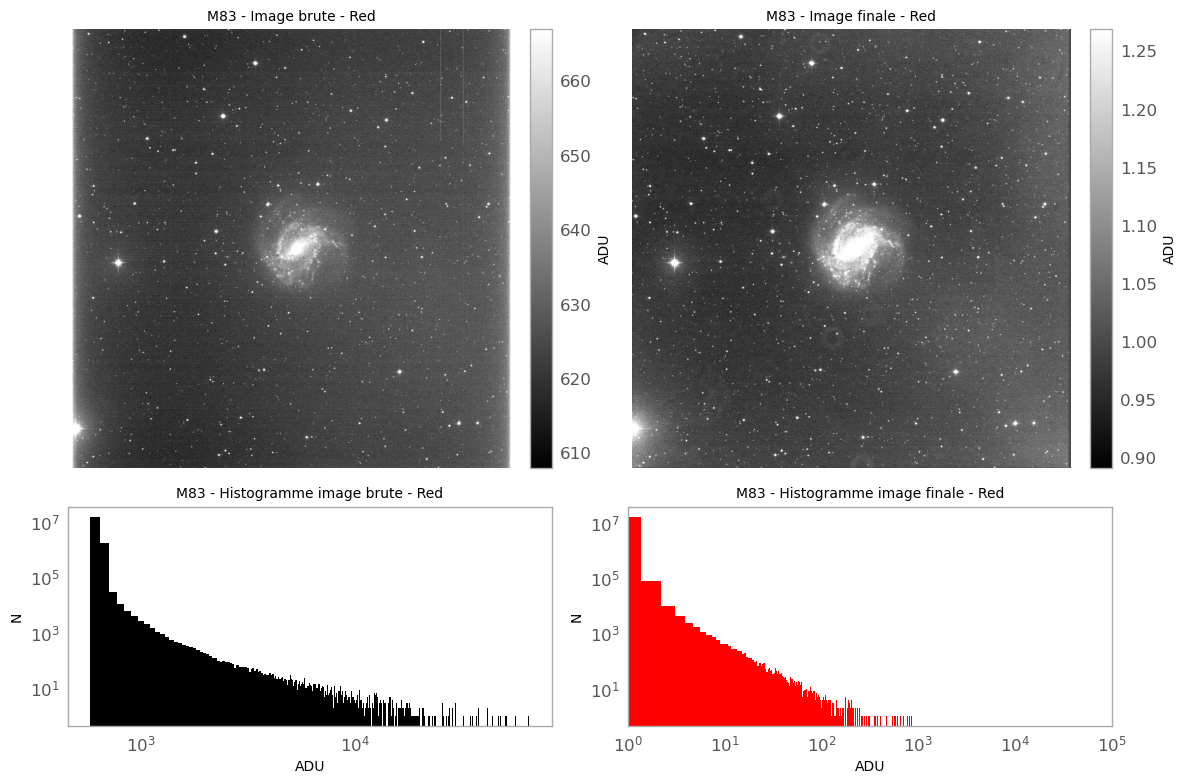

In [157]:
props = {
    'galaxy_name': 'M83',
    'input_folder': './M83/',
    'bias_path': './Processed/masterbias.fits',
    'flat_folder': './flats_maitre/',
    'output_folder': './Processed/',
    'color_init': 'black',
    'override_master_filename': False,
    'os': os
}
filter_red_props = { **props, 'filter_name': 'Red', 'color_final': 'red'}
utils.plot_images_and_histograms(filter_red_props)

pattern ./M83/M83-Blue-*.fit
Trouvé 5 fichiers pour le filtre Blue.
--- Pose individuelle ---
M83 Image brute : Moyenne : 697.71 ADU, Ecart-type : 287.47
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.02 ADU, Ecart-type : 1.98


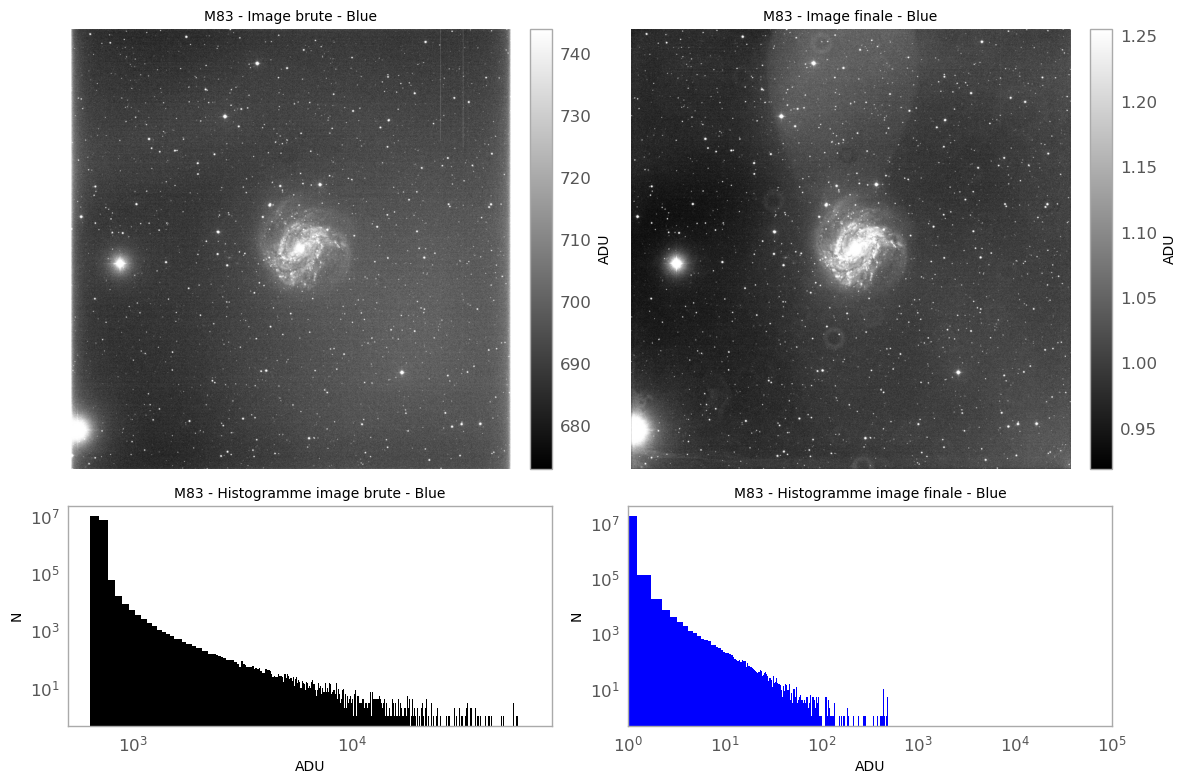

In [88]:
filter_blue_props = { **props, 'filter_name': 'Blue', 'color_final': 'blue'}
utils.plot_images_and_histograms(filter_blue_props)

In [91]:
filter_green_props = { **props, 'filter_name': 'Green', 'color_final': 'green' }
utils.plot_images_and_histograms(filter_green_props)

pattern ./M83/M83-Green-*.fit
Trouvé 5 fichiers pour le filtre Green.
--- Pose individuelle ---
M83 Image brute : Moyenne : 670.85 ADU, Ecart-type : 287.33
--- Image finale stackée ---
M83 Image finale: Moyenne : 1.03 ADU, Ecart-type : 2.45


En analysant les images avant et après calibration dans les trois filtres (Rouge, Vert et Bleu), nous pouvons observer plusieurs améliorations significatives :

1. Avec la calibration du bias, on a pu éliminer d'une façon efficace des imperfections électroniques du détecteur, ainsi que des traces blanches parasites présentes dans l'image brute, et principalemente une réduction notable du bruit de fond systématique.

2. L'effet du master flat a un effet d'homogénéisation remarquable du fond de ciel, ainsi une correction du vignettage (aux bords). On a pu aussi supprimer des motifs dus aux poussières sur l'optique, cependant l'image `master_flat` avait des motifs très visibles, alors quelques unes sont restés dans l'image calibrée.

Ces améliorations permettent une analyse photométrique plus fiable et une meilleure caractérisation de la structure galactique. Finalement on pourra afficher l'image calibrée en `RBG`, pour cela utilisons la fonction `plot_image_in_color`.

pattern ./M83/M83-Red-*.fit
Trouvé 5 fichiers pour le filtre Red.
pattern ./M83/M83-Green-*.fit
Trouvé 5 fichiers pour le filtre Green.
pattern ./M83/M83-Blue-*.fit
Trouvé 5 fichiers pour le filtre Blue.


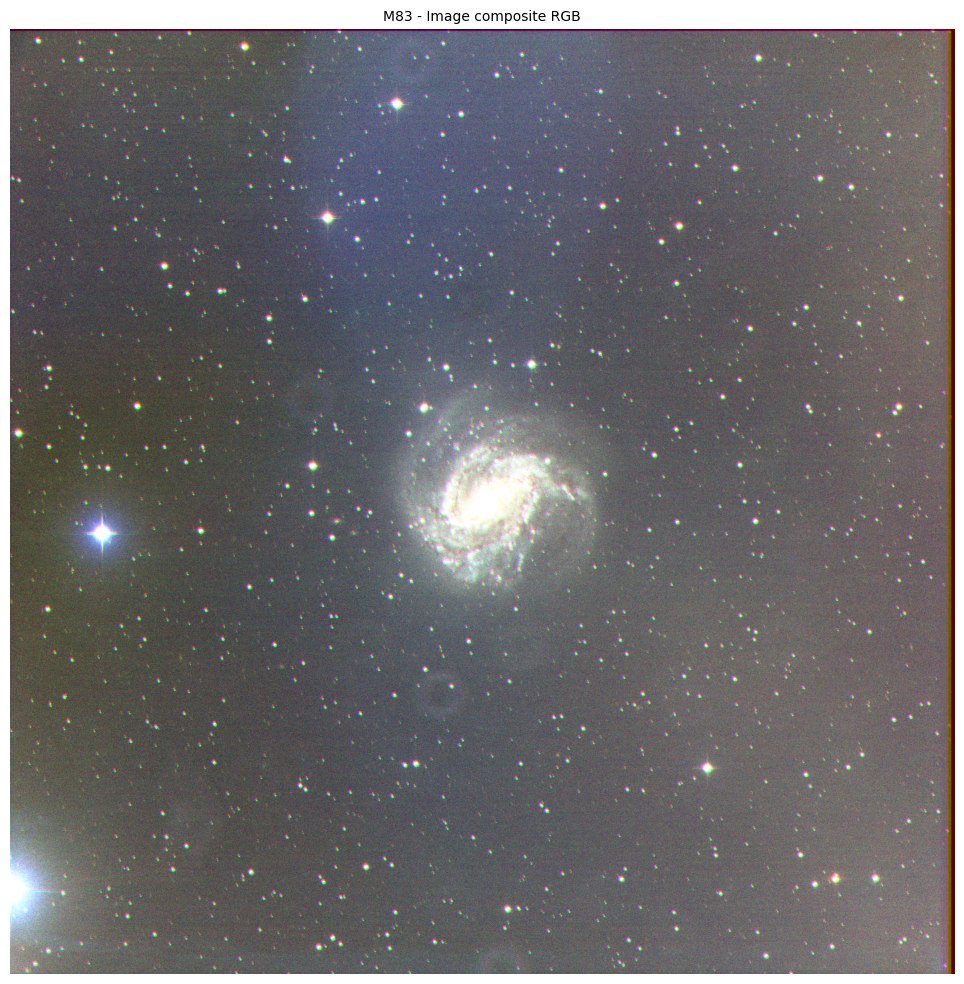

In [95]:
filters_props = [
    filter_red_props,
    filter_green_props,
    filter_blue_props
]
utils.plot_image_in_color(filters_props)

**Quelques remarques pour la construction de cette image**

La création d'une image RGB à partir de trois filtres distincts nécessite plusieurs étapes de traitement pour assurer un alignement et une normalisation optimaux.

Le défi principal vient du fait que les images obtenues à travers les différents filtres (Rouge, Vert, Bleu) présentent de légers décalages. 

Pour corriger ces décalages :

1. Pour chaque filtre, détection du pixel le plus brillant comme point de référence.
2. Utilisation du filtre Rouge comme référence principale (dans notre cas).
3. Calcul des décalages ($\Delta x$, $\Delta y$) des autres filtres par rapport à cette référence.
4. Application des translations nécessaires pour aligner les images

Finalement un procesuss d'uniformisation des dimensions et normalisation des intensités où on supprimme les valeurs extrêmes (1er et 99 percentiles).

Cette séquence permet d'obtenir trois images parfaitement alignées et normalisées qui peuvent être combinées en une image RGB cohérente.

## 5. Prises de vue à partir de l’observatoire à distance


**Observation à distance de `NGC4535`**

Pour réaliser notre observation à distance, nous avons utilisé deux plateformes:

- **Telescopius** [11] pour planifier les observations en identifiant les fenêtres d'observation optimales depuis le SSO.
- **iTelescope.net** [12] pour l'acquisition des données

La galaxie `NGC4535` présentait une fenêtre d'observation optimale entre 22h et 23h (GMT+10) le 29 avril 2025. Notre choix s'est porté sur le télescope `T17`, suite à un problème technique sur le `T32` initialement prévu (défaut de lentille).

La chronologie de la session c'était:

1. Sélection de la cible et des paramètres d'observation et création du script de réglages.
2. Mise en file d'attente sur le `T17` (déjà utilisé par un autre observateur)
3. Accès au télescope obtenu à 23h20 (GMT+10)
4. Début des acquisitions dans les filtres Rouge, Vert, Bleu.

Lors du déroulement de l'observation, nous avons constaté que les images de la galaxie n'étaient pas centrées. Cette situation est probablement due au fait que la fenêtre d'observation optimale était déjà passée au moment de notre acquisition. Néanmoins, malgré ce décalage, nous avons pu obtenir des images de qualité suffisante pour notre étude photométrique.

On peut voir les résultats obtenues de cette expérience.

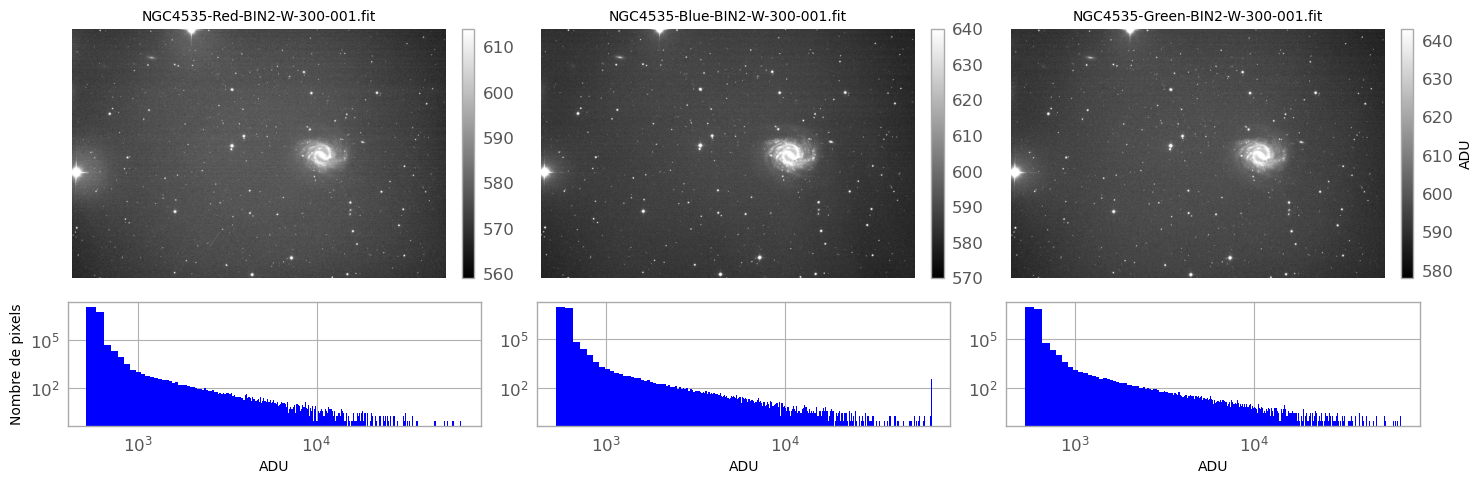

In [97]:
utils.plot_initial_filter_sequence('NGC4535', './T17/NGC4535/20250429/', ['Red', 'Blue', 'Green'])

Jusqu'au maintenant, on connait pas certaines informations photométriques importantes. Ces informations on peut les retrouver à la main en utilisant les informations de metadatas ou en s'en appuiyant dans logiciel comme Astrometry.net qui peremt identifier les objets presents dans le champ et fourni les coordonées precises de chaque objet trouvé ainsi que des informations astrométriques utiles pour valider l'observation.

Par exemple cela est l'image de toutes les objets que Astrometry a trouvé dans notre image brute.

<img src="./ngc4535-processed-rings.png">

In [108]:
utils.plot_bias_hist('./calibration-library/T17/Masters/Bias/2021-11/Master_Bias 1_1056x1027_Bin1x1_Temp-35C_ExpTime0ms.fit', 'NGC4535')

In [114]:
utils.plot_master_flat_hist('./calibration-library/T17/Masters/Flats/2021-11/2021-11-09-T17-Master-Flat-Bin2-Red.fit', 'NGC4535')

Valeur moyenne des pixels: 29616.02 ADU


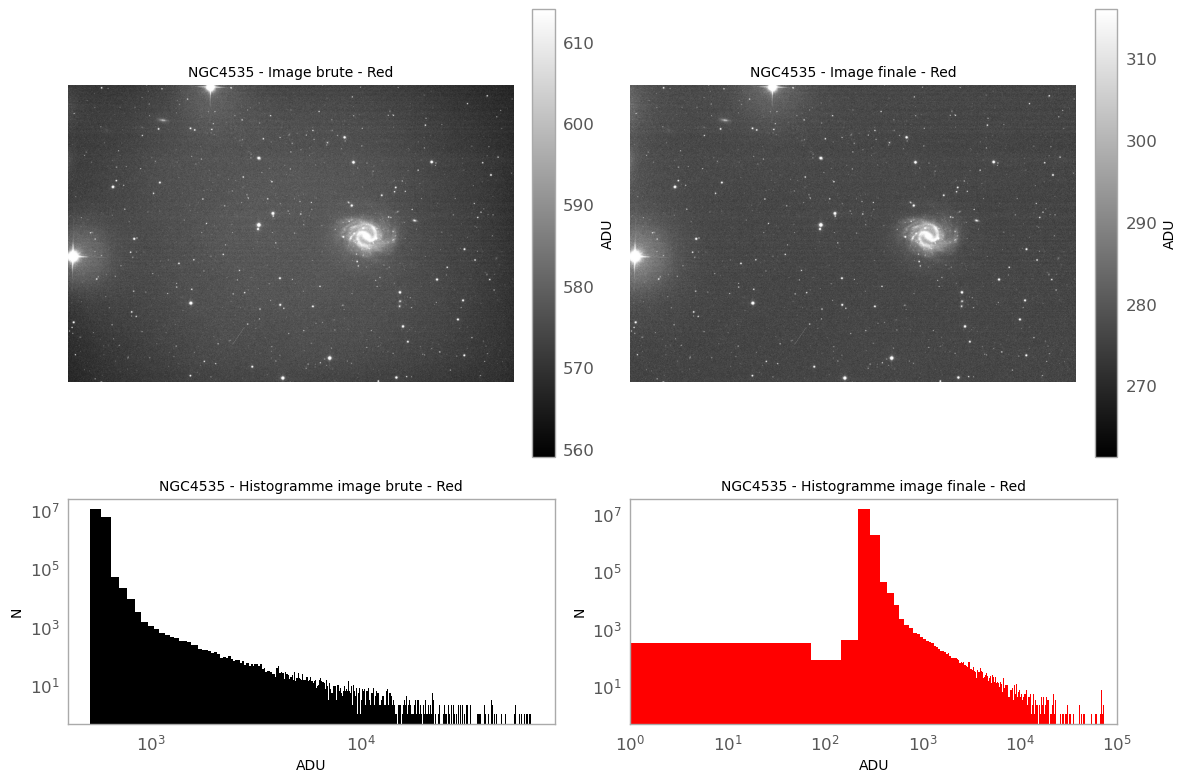

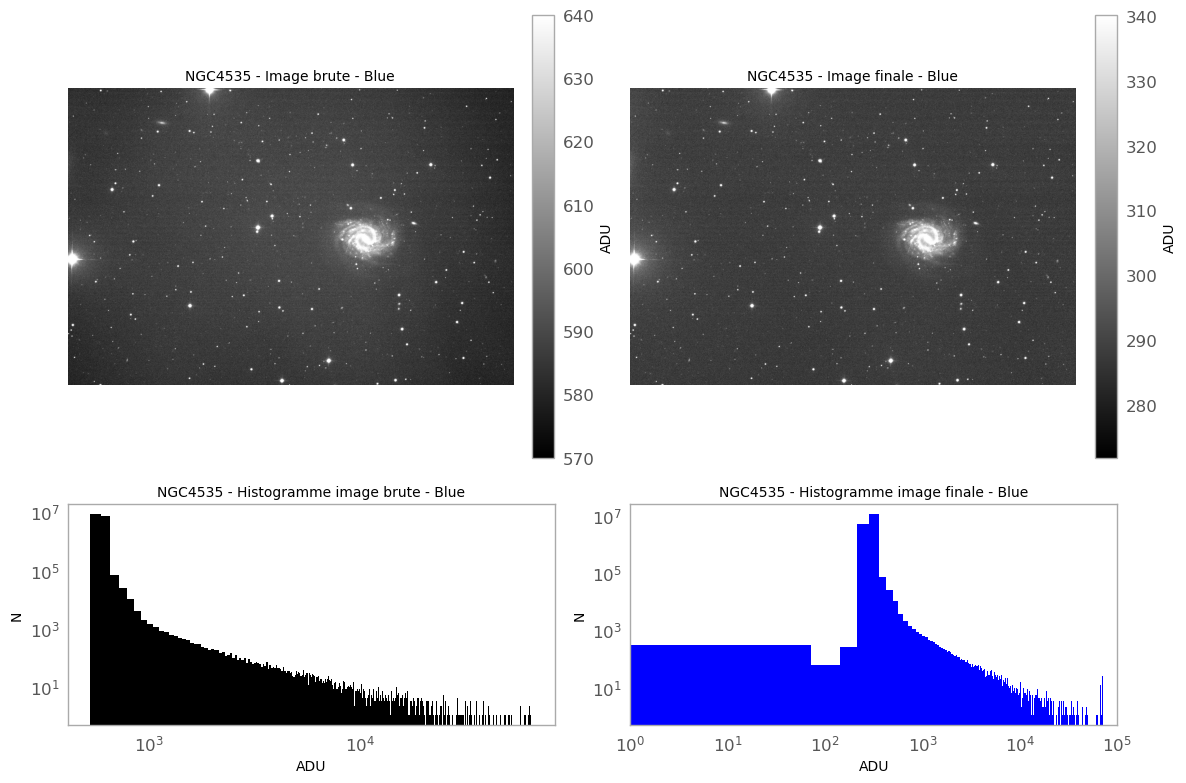

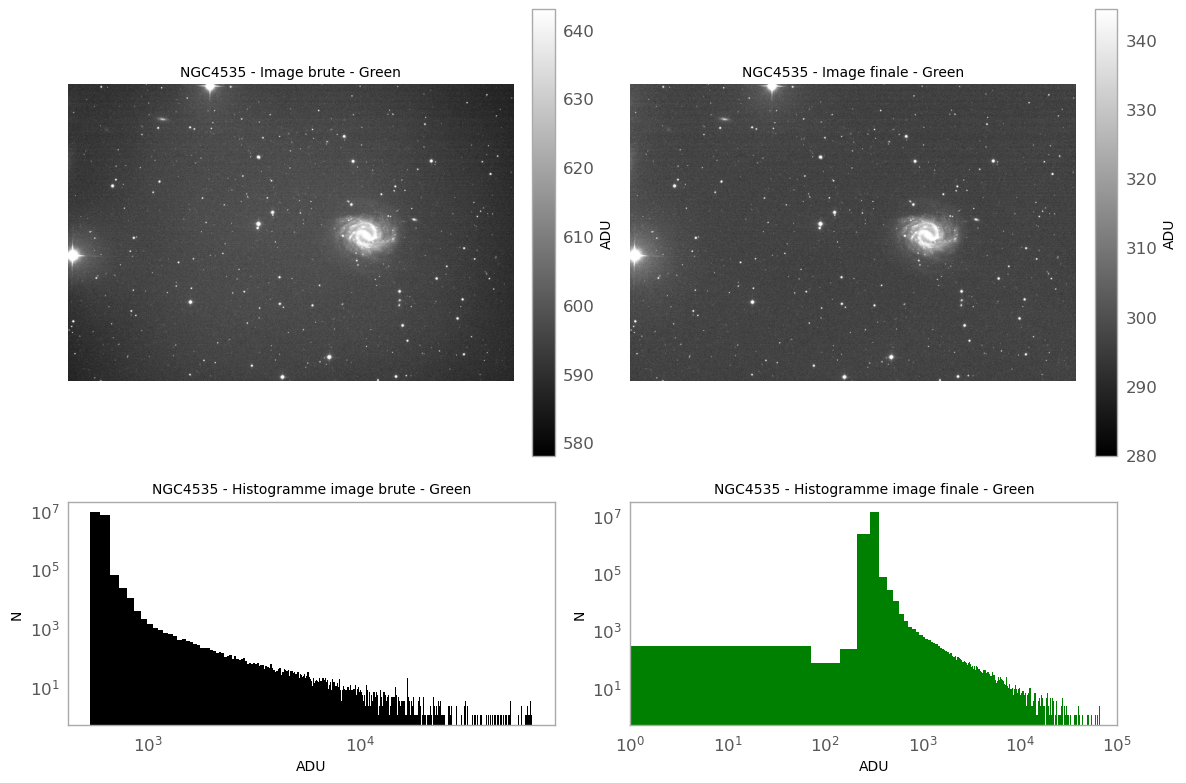

In [168]:
utils.plot_custom_images_and_histograms({
    'galaxy_name': 'NGC4535',
    'filter_name': 'Red',
    'color_init': 'black',
    'color_final': 'red',
    'initial_filename': './T17/NGC4535/20250429/NGC4535-Red-BIN2-W-300-001.fit',
    'final_filename': './T17/NGC4535/20250429/calibrated-T17-NGC4535-Red-BIN2-W-300-001.fit',
})

utils.plot_custom_images_and_histograms({
    'galaxy_name': 'NGC4535',
    'filter_name': 'Blue',
    'color_init': 'black',
    'color_final': 'blue',
    'initial_filename': './T17/NGC4535/20250429/NGC4535-Blue-BIN2-W-300-001.fit',
    'final_filename': './T17/NGC4535/20250429/calibrated-T17-NGC4535-Blue-BIN2-W-300-001.fit',
})

utils.plot_custom_images_and_histograms({
    'galaxy_name': 'NGC4535',
    'filter_name': 'Green',
    'color_init': 'black',
    'color_final': 'green',
    'initial_filename': './T17/NGC4535/20250429/NGC4535-Green-BIN2-W-300-001.fit',
    'final_filename': './T17/NGC4535/20250429/calibrated-T17-NGC4535-Green-BIN2-W-300-001.fit',
})

## 5. Photométrie : taille et luminosité

On fera une analyse de chaque galaxie pour savoir

> Sachant la distance de la galaxie et la taille angulaire d'un pixel (spécifiées dans le [tableur excel](https://dropsu.sorbonne-universite.fr/apps/onlyoffice/s/KRR4sWN4dJsSjmg) ), calculer le facteur de conversion entre pixel et kpc pour cette galaxie.

In [15]:
pixel_size_kpc = utils.get_pixel_size_in_kpc(pixel_size, distance_mpc) # kpc/pixel
print(f"Taille du pixel : {pixel_size_kpc:.3f} kpc/pixel")

Taille du pixel : 0.014 kpc/pixel


> Calculer le flux de la galaxie dans differentes ouvertes entre 0.1 et 10kpc

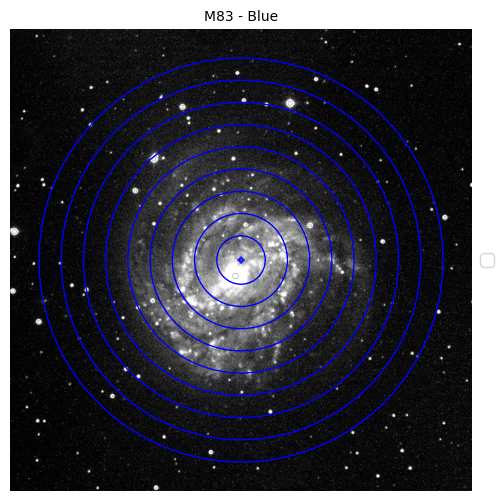

In [16]:
image_calibrated = utils.get_image_calibrated('./Processed/M83_Blue_final_calibrated.fits')
rad_list = np.linspace(0.1,10,10) # kpc
flux_list, bckg = utils.return_flux(image_calibrated,rad_list,pixel_size_kpc,search_center=True,rm_background=True,diagnostic=True, galaxy_name='M83', filter_name='Blue', color='blue')

> Calculer the *total luminosity* and *the effective radius (radius that encloses half the total luminosity)*

In [17]:
lum,rad,rad_tot = utils.size_luminosity(rad_list,flux_list)
print(f"Le flux totale : {lum[0]:.2e} ADU")
print(f"Effective radius : {rad[0]} kpc")
print(f"Minimum radius : {rad_tot[0]} kpc")

Le flux totale : 9.28e+04 ADU
Effective radius : 4.5 kpc
Minimum radius : 10.0 kpc


> Les luminosités apparentes (`flux_list` et `lum`) sont en unite électronique. En utilisant le point zero indiqué dans le tableau excel, les convertir en magnitudes apparentes AB

In [18]:
zero_point = 19.05 # ZP for M83 with the T32 telescope

In [19]:
magnitudes = utils.calculate_magnitudes(flux_list, distance_mpc, rad_list, rad, zero_point)
print(f"La moyenne des magnitudes se trouve autour de {magnitudes['apparent_magnitudes'].mean():.2f} mag AB")
print(f"Magnitude effective {magnitudes['effective_magnitude']:.2f} mag AB")

La moyenne des magnitudes se trouve autour de 8.15 mag AB
Magnitude effective -21.09 mag AB


> Convertir les magnitudes apparentes en magnitudes rest-frame (c'est à dire à 10pc de la source)

In [20]:
print(f"La moyenne des magnitudes à 10pc de la source se trouve autour de {magnitudes['absolute_magnitudes'].mean():.2f} mag")

La moyenne des magnitudes à 10pc de la source se trouve autour de -20.19 mag


> Tracer l'evolution de la magnitude en fonction du rayon et ajouter une ligne verticale indiquant le rayon effectif

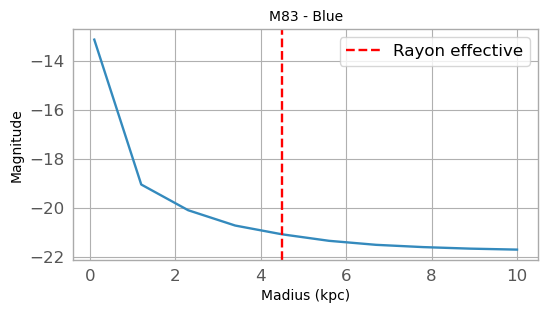

In [21]:
utils.plot_radial_magnitudes(magnitudes, rad_list, rad, 'M83', 'Blue')

> Faire la meme chose pour les autres galaxies dont vous avez les images calibrées

In [22]:
props = {
    'pixel_size' : pixel_size,
    'distance_mpc': distance_mpc,
    'galaxy_name': 'M83',
    'zero_point': 19.05
}
utils.process_size_luminosity({ **props, 'filter_name': 'Red', 'color': 'red' })

Taille du pixel : 0.014 kpc/pixel


Le flux totale : 106578.03 ADU
Effective radius : 3.40 kpc
Minimum radius : 8.90 kpc
La moyenne des magnitudes se trouve autour de 7.37 mag AB
Magnitude effective -21.16 mag AB
La moyenne des magnitudes à 10pc de la source se trouve autour de -20.97 mag


Taille du pixel : 0.014 kpc/pixel


Le flux totale : 100099.92 ADU
Effective radius : 3.40 kpc
Minimum radius : 10.00 kpc
La moyenne des magnitudes se trouve autour de 7.52 mag AB
Magnitude effective -20.95 mag AB
La moyenne des magnitudes à 10pc de la source se trouve autour de -20.82 mag


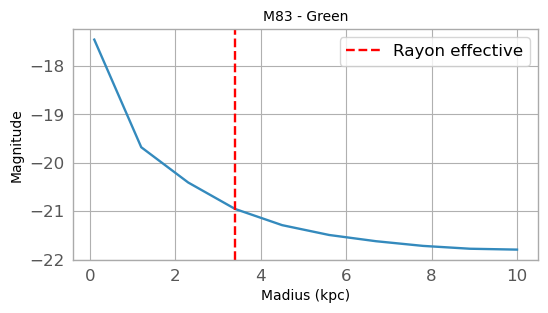

In [23]:
utils.process_size_luminosity({ **props, 'filter_name': 'Green', 'color': 'green' })

Taille du pixel : 0.014 kpc/pixel


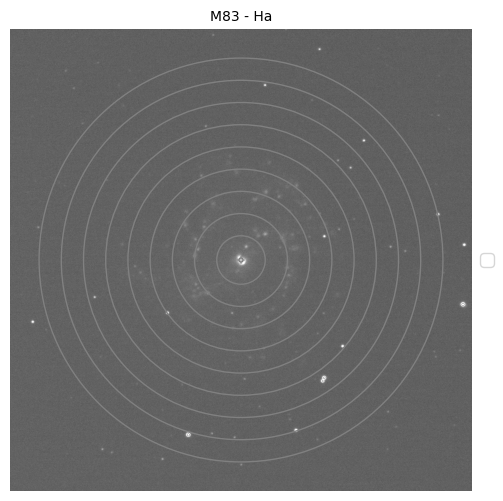

Le flux totale : 1514.59 ADU
Effective radius : 3.40 kpc
Minimum radius : 8.90 kpc
La moyenne des magnitudes se trouve autour de 11.92 mag AB
Magnitude effective -16.62 mag AB
La moyenne des magnitudes à 10pc de la source se trouve autour de -16.42 mag


In [24]:
utils.process_size_luminosity({ **props, 'filter_name': 'Ha', 'color': 'gray' })

> Sur la figure ci-dessous, rajouter vos points de mesure (dans les panneaux correspondants)

In [48]:
magz_ellipt, reff_ellipt, magz_disk, reff_disk = size_luminosity_data = utils.get_size_luminosity_data()
utils.plot_galaxies_with_incertitudes(magz_ellipt, reff_ellipt, magz_disk, reff_disk, magnitudes['effective_magnitude'], rad, galaxy_type, galaxy_name)

> Discuter des sources d'incertitudes, et des effets systematiques

// TODO

In [ ]:
from astroquery.vizier import Vizier
import pandas as pd

# Set Vizier row limit (you can change or set to -1 for all available rows)
Vizier.ROW_LIMIT = -1

# Define only the columns we need
columns = [
    "MType", "MType2",  # Morphology
    "gMAGd", "rMAGd", "iMAGd",  # Disk magnitudes
    "gMAGbu", "rMAGbu", "iMAGbu",  # Bulge magnitudes
    "h", "re",  # Disk scalelength and Bulge effective radius
    "Blg/T", "D/T", "Bar/T",  # Component ratios
    "z",  # Redshift
    "(g-i)d", "(g-i)bu"  # Color indices
]

# Load the table: J/MNRAS/393/1531 (Dimitri A. Gadotti 2009)
catalog_id = "J/MNRAS/393/1531"
vizier = Vizier(columns=columns)
result = vizier.get_catalogs(catalog_id)

# The main table is usually the first one
data = result[0].to_pandas()

# Preview the dataframe
print("Total entries:", len(data))
print(data.head())

# Optional: Filter Elliptical vs Disk
# For example: classify "Elliptical" as MType starting with 'E', "Disk" with 'S' or 'Sb' etc.
ellipticals = data[data["MType"].str.startswith("E", na=False)]
disks = data[data["MType"].str.startswith("S", na=False)]

print("Ellipticals:", len(ellipticals))
print("Disks:", len(disks))

Total entries: 50
          MType    MType2  gMAGd      rMAGd      iMAGd     gMAGbu     rMAGbu  \
0     classical  unbarred -19.74 -20.580000 -20.959999 -19.330000 -19.940001   
1     classical  unbarred -20.18 -20.879999 -21.340000 -19.410000 -20.680000   
2  pseudo-bulge  unbarred -20.18 -20.639999 -20.940001 -15.820000 -16.860001   
3    elliptical  unbarred    NaN        NaN        NaN -20.680000 -21.389999   
4    elliptical  unbarred    NaN        NaN        NaN -20.610001 -21.379999   

   iMAGbu      h     re  Blg/T    D/T  Bar/T      z  (g-i)d  (g-i)bu  
0  -20.33  2.103  1.244  0.359  0.641    0.0  0.067   1.222    1.001  
1  -21.27  2.409  1.827  0.483  0.517    0.0  0.047   1.170    1.862  
2  -17.24  2.189  0.523  0.032  0.968    0.0  0.043   0.760    1.421  
3  -21.74    NaN  2.735  1.000  0.000    0.0  0.063     NaN    1.060  
4  -21.83    NaN  3.120  1.000  0.000    0.0  0.056     NaN    1.214  
Ellipticals: 0
Disks: 0


In [ ]:
# For demonstration, use bulge effective radius vs. bulge i-band magnitude
x = data["iMAGbu"]
y = data["re"]

# Apply fixed uncertainties (you can refine these based on paper)
xerr = [0.1] * len(x)  # ±0.1 mag
yerr = 0.11 * y         # 20% of the effective radius

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
plt.gca().invert_xaxis()  # Bright galaxies have lower magnitudes
plt.xlabel("Bulge i-band Magnitude (iMAGbu)")
plt.ylabel("Bulge Effective Radius (re) [arcsec or kpc]")
plt.title("Effective Radius vs. Bulge Magnitude (with estimated errors)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
magnitudes['effective_magnitude'], rad

In [ ]:
import matplotlib.pyplot as plt

# Ellipticals: use bulge i-band magnitude and bulge effective radius
#ellipticals = data[data["MType"].str.startswith("E", na=False)]
#ellipticals = ellipticals[["iMAGbu", "re"]].dropna()

# Ellipticals
ellipticals = data[data["MType"] == "elliptical"][["iMAGbu", "re"]].dropna()

# Disks – select bulgeless, pseudo-bulge, or classical (depending on your definition)
disks = data[data["MType"].isin(["pseudo-bulge", "classical", "bulgeless"])][["iMAGd", "h"]].dropna()


x_e = ellipticals["iMAGbu"]
y_e = ellipticals["re"]
xerr_e = [0.1] * len(x_e)
yerr_e = 0.2 * y_e  # 20% uncertainty on effective radius

# Disks: use disk i-band magnitude and disk scalelength
# disks = data[data["MType"].str.startswith("S", na=False)]
#disks = disks[["iMAGd", "h"]].dropna()
x_d = disks["iMAGd"]
y_d = disks["h"]
xerr_d = [0.1] * len(x_d)
yerr_d = 0.2 * y_d  # 20% uncertainty on scalelength

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot ellipticals
axs[0].errorbar(x_e, y_e, xerr=xerr_e, yerr=yerr_e, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
axs[0].invert_xaxis()
axs[0].set_title("Ellipticals (Bulge-dominated)")
axs[0].set_xlabel("Bulge i-band Magnitude (iMAGbu)")
axs[0].set_ylabel("Effective Radius (re) [arcsec]")

# Plot disks

axs[1].scatter(magnitudes['effective_magnitude'], rad, color='green', s=100, alpha=0.9, label='M83')
axs[1].errorbar(magnitudes['effective_magnitude'], rad, xerr=[0.1], yerr=[0.2 * rad[0]], fmt='o', color='green', ecolor='green', alpha=0.9)

axs[1].errorbar(x_d, y_d, xerr=xerr_d, yerr=yerr_d, fmt='o', ecolor='gray', alpha=0.6, markersize=4)
axs[1].invert_xaxis()
axs[1].set_title("Disks (Disk-dominated)")
axs[1].set_xlabel("Disk i-band Magnitude (iMAGd)")

plt.suptitle("Galaxy Size vs. Magnitude (Gadotti 2009)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# 6.2

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry

# Charger ton image finale calibrée
image_data = fits.getdata('./Processed/M83_Red_final_calibrated.fits')  # Exemple avec Red

# Définir le centre de la galaxie (à ajuster si besoin)
x_center = 2048
y_center = 2048
positions = [(x_center, y_center)]

# Définir différentes tailles d'ouverture (en pixels)
radii = [50, 100, 150, 200, 250]  # Rayons en pixels

# Faire des mesures d'ouverture
for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(image_data, aperture)
    flux = phot_table['aperture_sum'][0]
    print(f"Rayon : {r} pixels → Flux mesuré : {flux:.2f} ADU")


In [ ]:
# Photométrie simple avec photutils
from photutils.aperture import CircularAperture, aperture_photometry

positions = [(x0, y0)]  # centre de la galaxie
radii = [10, 15, 20, 25, 30]  # à adapter

for r in radii:
    aperture = CircularAperture(positions, r=r)
    phot_table = aperture_photometry(stacked_image, aperture)
    print(f"Rayon {r}: flux = {phot_table['aperture_sum']}")

## 6. Étude statistique loi taille-luminosité

In [ ]:
# Exemple de tracé final
luminosities = [...]  # µJy
radii_kpc = [...]     # kpc
types = [...]         # par exemple ["spirale", "elliptique", ...]

plt.scatter(luminosities, radii_kpc, c=type_color_map[types], label=types)
plt.xlabel("Luminosité (µJy)")
plt.ylabel("Rayon effectif (kpc)")
plt.title("Relation taille-luminosité")
plt.legend()
plt.grid()
plt.show()

## 7. Discussion

- Incertitudes principales :
  * fond de ciel
  * étalonnage du point-zéro
  * qualité des poses
- Comportement selon le type morphologique ?
- Alignement avec les résultats de Gadotti (2009) ?


3. **Implications physiques**
   - La distribution de brillance à travers les filtres nous renseigne sur l'histoire de formation stellaire
   - Les variations entre filtres permettent de cartographier différentes populations stellaires et phases du milieu interstellaire

   3. **Améliorations spécifiques par filtre** :
   - **Filtre Rouge** : Meilleure définition des régions périphériques de la galaxie
   - **Filtre Vert** : Contraste accru des structures spirales
   - **Filtre Bleu** : Meilleure visibilité des régions de formation stellaire

4. **Qualité photométrique** :
   - Distribution plus uniforme des valeurs de fond de ciel
   - Meilleur rapport signal/bruit
   - Conservation des détails fins dans les régions centrales
   - Dynamique améliorée dans les zones de faible luminosité

## Bibliographie

[1] Hubble, E. (1926) "Extra-galactic nebulae", ApJ, 64, 321

[2] Kormendy & Bender (1996) "A proposed revision of the Hubble sequence for elliptical galaxies", ApJL, 464, L119

[3] Carroll & Ostlie (2006) "An Introduction to Modern Astrophysics"

[4] Elmegreen et al. (2012) "Galaxy Morphology", Annual Review of Astronomy and Astrophysics, 50, 531

[5] Conselice (2014) "The Evolution of Galaxy Structure Over Cosmic Time", ARA&A, 52, 291

[6] Calzetti et al. (2007) "The Calibration of Mid-Infrared Star Formation Rate Indicators", ApJ, 666, 870

[7] Kennicutt (1998) "Star Formation in Galaxies Along the Hubble Sequence", ARA&A, 36, 189

[8] Leinert et al. (1998) "The 1997 reference of diffuse night sky brightness", A&AS, 127, 1

[9] Thilker et al. (2005) "Recent Star Formation in the Extreme Outer Disk of M83", ApJ, 619, L79

[10] Astrobasics. Bias, Flats, Darks, Darkflats. https://astrobasics.de/en/basics/bias-flats-darks-darkflats/

[11] Telescopius – [https://telescopius.com](https://telescopius.com)

[12] iTelescope.net – [https://www.itelescope.net](https://www.itelescope.net)

[13] Astrometry.net – [https://nova.astrometry.net](https://nova.astrometry.net)